# Data Mining Term Project

Author: **Harsh Kishan Daga**
<br>
UTA ID: **100 177 1009**

---

<br>

**Purpose:**
<br>
The purpose of this notebook is to classify (predict) the rating of a review for any games.<br>
I start with cleaning and preprocessing the input data which is plain text.<br>
The input data has fractional ratings while we only predict ratings in the integer range $[0,10]$.<br>
This is done by rounding off the original ratings to bring them into $[0,10]$ integer range.<br>
Since the dataset is massive (2.9 million reviews), the models created here are trained on a random sample of 10,000 reviews.<br>
I start off by using a SVM since it trains faster than most of the alternatives like NBC but after analysing the predictions from a single SVM, there's a significant flaw in the predictions (explained further in the notebook).<br>
I attempt to resolve that using another SVM that it trained using "balanced" train data(explain further) and then using a Decision Tree on the outputs of both SVMs to decide the final prediction.





<br>

Imports and setting up the notebook environment for plotting.

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import nltk
import random
import matplotlib.mlab as mlab
import seaborn as sns
import math
from nltk.corpus import stopwords
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from google.colab import drive, files

In [ ]:
sns.set(color_codes=True)

The data to train on is in a csv file on my Google Drive.<br>
I can fetch the files this way.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Stopwords* are words that are filtered before processing the text since they don't contribute to the sentiment of the text.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Reading Data

After reading the csv file, I drop the `user` and `name` columns to save some memory.

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bgg-15m-reviews.csv', index_col=0)
data = data.drop(['user', 'name'], axis=1)
data

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,rating,comment,ID
0,10.0,NaN,30549
1,10.0,Hands down my favorite new game of BGG CON 200...,30549
2,10.0,I tend to either love or easily tire of co-op ...,30549
3,10.0,NaN,30549
4,10.0,This is an amazing co-op game. I play mostly ...,30549
...,...,...,...
15823264,8.0,Turn based preview looks very promising. The g...,281515
15823265,8.0,KS,281515
15823266,7.0,NaN,281515
15823267,6.0,NaN,281515


# Filtering Data

Looking at the data above, we can see that a low of the rows are missing a `comment`.<br>
These rows are removed from the dataset.<br>
Additionally, I also compute the word count of each review since I'll be using this later for further filtering.<br>
Finally, the fractional ratings are rounded off to integer and store in `rating_int`.

In [ ]:
data = data[data.comment.notna()]
data['word_count'] = data.comment.str.split().str.len()
data['rating_int'] = data.rating.astype('int')
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,rating,comment,ID,word_count,rating_int
1,10.0,Hands down my favorite new game of BGG CON 200...,30549,84,10
2,10.0,I tend to either love or easily tire of co-op ...,30549,73,10
4,10.0,This is an amazing co-op game. I play mostly ...,30549,59,10
5,10.0,Hey! I can finally rate this game I've been pl...,30549,215,10
8,10.0,Love it- great fun with my son. 2 plays so far...,30549,16,10
...,...,...,...,...,...
15823242,10.0,KS Collector's Bundle with a friend of mine,281515,8,10
15823247,10.0,Belekokio Gerumo...,281515,2,10
15823253,10.0,Excelente!! lo mejor que probé.,281515,5,10
15823264,8.0,Turn based preview looks very promising. The g...,281515,95,8


The size of the dataset went from **15.8 million** rows to **~3 million rows**!<br>
Out of these, I discard the reviews that are too short or too long.<br>
The short reviews are discarded because they aren't as useful in training the models.<br>
The long reviews are discarded because they will slow down the training significantly.

In [ ]:
usable_data = data[(data.word_count > 10) & (data.word_count < 200)]

The dataset is still too large to train the model on.<br>
Going forward, I work with a random sample of the data of size `sample_size`.

In [ ]:
sample_size = 10000

In [ ]:
working_data = usable_data.sample(n=sample_size)
working_data

,rating,comment,ID,word_count,rating_int
5699294,8.0,Can be complicated to teach (people often don'...,9216,66,8
12680398,6.0,Race game where you playa card that may impact...,101,40,6
13060893,6.0,While the water management puzzle is interesti...,149119,60,6
12701336,9.0,Favorite Diplomacy-variant. My rating is a 9 o...,286,36,9
3519550,7.0,My first coop game and still my favorite. Perh...,30549,23,7
...,...,...,...,...,...
8035854,3.0,if you have to role-play for it to be a good g...,929,44,3
10350755,7.0,All of the stuff I read about this game indica...,6351,159,7
14050764,7.0,I have the Chaosium version. One of the best ...,1720,27,7
11686860,7.0,"This has a better theme, but I prefer [i][game...",73,21,7


Most of the reviews in the random sample above follow the same rating distribution as the original data which leaves us with too few reviews with extreme ratings.<br>
So I create a second sample of reviews which is "balanced" such that we have the same number of reviews for each prediction class (`rating_int`).

In [ ]:
grouped = usable_data[usable_data.rating_int != 0].groupby(['rating_int'])
working_data_balanced = grouped.apply(lambda x: x.sample(n=sample_size//10))
working_data_balanced

rating  ... rating_int
rating_int                   ...           
1          14770563     1.0  ...          1
           12423471     1.0  ...          1
           11611053     1.0  ...          1
           11386505     1.0  ...          1
           15443746     1.0  ...          1
...                     ...  ...        ...
10         268994      10.0  ...         10
           7412679     10.0  ...         10
           8136857     10.0  ...         10
           5356382     10.0  ...         10
           3668141     10.0  ...         10

[10000 rows x 5 columns]

# Cleaning Data

In addition to the stopwords from `nltk`, I added a few words of my own since I know these reviews are for games and the following words will occur frequently even though they help in conveying the sentiment of the review.

In [ ]:
stopwords_set = set(stopwords.words('english'))
stopwords_set = stopwords_set.union(('game','play','played','players','player','people','really','board','games','one','plays','cards','would'))

I define a function to clean the reviews in a `Dataframe`.<br>
All punctuations are removed from the review text.<br>
All stopwords are removed as well.

In [ ]:
def clean_data(df):
  df['cleaned'] = df['comment'].str.lower().apply(lambda x:''.join([i for i in x if i not in string.punctuation]))
  df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))
  df['rating_int'] = df['rating'].astype('int')
  return df

Cleaning the 2 data samples from earlier.

In [ ]:
clean_data(working_data)
clean_data(working_data_balanced)

`Data` class is defined to split and store the `Dataframe` into `train` and `test` datasets.

In [ ]:
class Data:
  def __init__(self, df, test_size=0.20, feat_cols = 'cleaned', result_col='rating_int'):
    df = df.copy()
    clean_data(df)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(df[feat_cols], df[result_col], test_size=0.20)
  
  @property
  def train(self):
    return self.X_train, self.y_train
  
  @property
  def test(self):
    return self.X_test, self.y_test

Creating `Data` objects from the 2 cleaned random data samples created earlier.

In [ ]:
data_unbalanced = Data(working_data, 0.20)
data_balanced = Data(working_data_balanced, 0.20)

`eval_model` computes the accuracy of a model on the given data and plots the confusion matrix for the predictions againt the actual ratings.

In [ ]:
def eval_model(name, model, X, y):
  _y_pred = model.predict(X)
  acc = accuracy_score(y, _y_pred)
  conf_mat = confusion_matrix(y, _y_pred, labels=list(range(1, 11)))

  sns.heatmap(conf_mat.T, square=False, annot=True, cbar=False, fmt='d')
  plt.xlabel('actual')
  plt.ylabel('predicted');
  plt.show()

  print(f'Accuracy of {name} = {acc}')

# SVM

This is the first SVM model that I use.<br>
It's defined as a pipeline since the text needs to be converted into numerical features before being fed into a SVM.<br>
The conversion of text to numerical features is done using $TF-IDF$.
The first stage of the pipleline is a `TfidfVectorizer` which also creates [bigrams](https://en.wikipedia.org/wiki/Bigram).<br>
The second step is a `SVC` classifier using `rbf` kernel instead of `linear` since `rbf` trades faster training for higher accuracy.

In [ ]:
model_svm = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer(lowercase = True, stop_words = stopwords_set, ngram_range=(1, 2))),
    ('classifier', svm.SVC(kernel="rbf", probability=True, cache_size=2048))
    ])

Training the SVM to unabalanced data sample.

In [ ]:
model_svm.fit(*data_unbalanced.train)

Pipeline(steps=[('tfidf_transformer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'board', 'both', 'but', 'by',
                                             'can', 'cards', ...})),
                ('classifier', SVC(cache_size=2048, probability=True))])

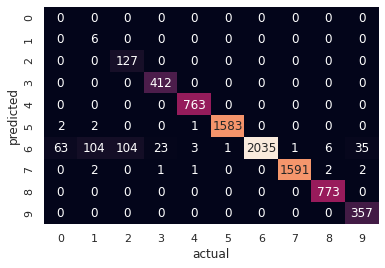

Accuracy of SVM = 0.955875


In [ ]:
eval_model('SVM', model_svm, *data_unbalanced.train)

That's a really good train accuracy and it's worth noting that <br>
most of the wrongly predicted reviews are for `rating == 6`.

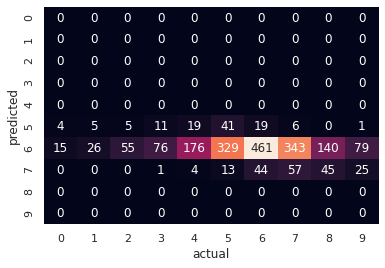

Accuracy of SVM = 0.2795


In [ ]:
eval_model('SVM', model_svm, *data_unbalanced.test)

The test accuracy isn't as good, and this was expected. <br>
But what's significant here is that the model has only predicted ratings between $4$ and $7$!<br>
Looks like the model has been overfit around the mean of the ratings.

# SVM Balanced Data

This is another SVM defined in the exact same manner as above but it will be trained on a different data sample.

In [ ]:
model_svm2 = Pipeline([
    ('tfidf_transformer', TfidfVectorizer(lowercase = True, stop_words = stopwords_set, ngram_range=(1, 2))),
    ('classifier', svm.SVC(kernel="rbf", probability=True, cache_size=2048))
    ])

This SVM is not trained on balanced data sample. <br>
It should be predicting ratings more uniformly now.

In [ ]:
model_svm2.fit(*data_balanced.train)

Pipeline(steps=[('tfidf_transformer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'board', 'both', 'but', 'by',
                                             'can', 'cards', ...})),
                ('classifier', SVC(cache_size=2048, probability=True))])

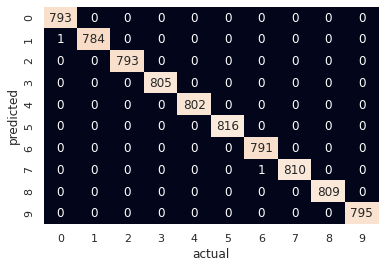

Accuracy of SVM2 = 0.99975


In [ ]:
eval_model('SVM2', model_svm2, *data_balanced.train)

A **very** high train accuracy!

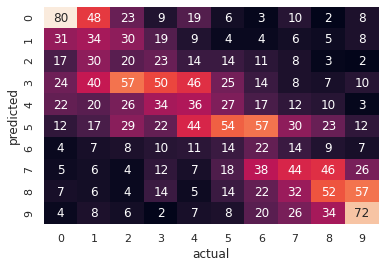

Accuracy of SVM2 = 0.232


In [ ]:
eval_model('SVM2', model_svm2, *data_balanced.test)

The test accuracy is worse now **BUT** this model is predicting ratings all across the matrix now.<br>
Also, most of the wrongly predicted ratings aren't that far off from the actual rating.<br>
An actual rating of $2$ being wrongly predicted as $3$ is not as bad as being predicted as $7$.

# Decision Tree
Now that we have 2 SVMs trained and ready to use, we need a third classifier to get the prediction results of these 2 SVMs and predict a final rating.<br>
A third random data sample is created for the final classifier and we add the predictions of the above 2 SVMs as features to this new data sample.

In [ ]:
all_working_data = usable_data.sample(n=sample_size)
clean_data(all_working_data)
all_working_data['unbalanced'] = model_svm.predict(all_working_data['cleaned'])
all_working_data['balanced'] = model_svm2.predict(all_working_data['cleaned'])
all_working_data['average'] = np.average(all_working_data[['balanced', 'unbalanced']])
all_working_data

,rating,comment,ID,word_count,rating_int,cleaned,unbalanced,balanced,average
1130885,8.0,Tight and interactive game. An interesting mec...,148949,26,8,tight interactive interesting mechanic gies op...,7,8,6.68125
14502393,8.0,A pretty solid set collection game with differ...,85800,34,8,pretty solid set collection different powers p...,7,7,6.68125
7511033,8.0,(07/14/2017) - Grabbed as part of a large Mini...,204027,63,8,07142017 grabbed part large miniature market c...,7,6,6.68125
11362666,6.3,Bρισκομαστε στην Αιγυπτο και θα πλιατσικολογησ...,98315,112,6,bρισκομαστε στην αιγυπτο και θα πλιατσικολογησ...,7,10,6.68125
412346,7.0,"Classic game. First ""real"" board game I was ev...",181,11,7,classic first real ever exposed,7,1,6.68125
...,...,...,...,...,...,...,...,...,...
1947623,8.0,I feel like this is a solid introduction to th...,129622,31,8,feel like solid introduction micro dont feel l...,7,6,6.68125
13407925,8.0,"Auténtica locura cometida, me lo he pillado en...",249746,25,8,auténtica locura cometida lo pillado en ks lle...,7,9,6.68125
13627597,5.0,Just kind of meh. Too bad I really wanted to ...,160784,13,5,kind meh bad wanted like,6,4,6.68125
12840246,8.0,A gripping simulation of the Normandy landings...,730,155,8,gripping simulation normandy landings immediat...,7,4,6.68125


In [ ]:
all_working_data['average'] = (all_working_data['balanced'] + all_working_data['unbalanced']) / 2

In [ ]:
data_final = Data(all_working_data, 0.2, feat_cols=['balanced', 'unbalanced'])

I used a decision tree as the final classifier to combine the results of both SVMs.<br>
A Decision Tree is a good choice here since we're predicting a single review out of 2 reviews as input.<br>

In [ ]:
model_final = DecisionTreeClassifier()
model_final.fit(*data_final.train)

DecisionTreeClassifier()

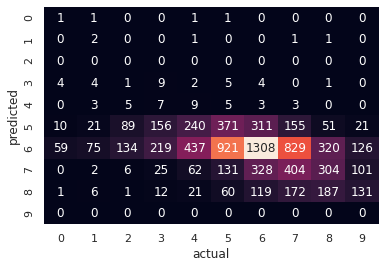

Accuracy of final = 0.286375


In [ ]:
eval_model('final', model_final, *data_final.train)

So the accuracy is about $28.6\%$ now and the predictions are spread out across the confusion matrix instead of being confined to a tight region around the mean. <br>
**Note:** The previous 2 SVMs were not retrained to be used in this decision tree.

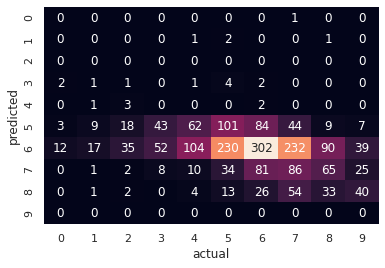

Accuracy of final = 0.261


In [ ]:
eval_model('final', model_final, *data_final.test)

A final accuracy of $26.1\%$. <br>
The confusion matrix looks concentrated around a rating of $6$ because that's the mean of ratings and the random sample that we chose had more reviews around this rating. <br>
The final model still attempted to predict ratings on the extremes but not so accurately.

The 3 models that are required to make a prediction are saved to be used outside of this notebook.

In [ ]:
import joblib

joblib.dump(model_svm, 'svm.pkl')
joblib.dump(model_svm2, 'svm_balanced.pkl')
joblib.dump(model_final, 'decision_tree.pkl')

['decision_tree.pkl']

# Summary

The final model is a combination of 2 SVMs and a decision tree.

![](https://drive.google.com/uc?export=view&id=1Aok3WqMVgYStNk0LYQHg8eV3HRzoDZgT)

<br>

However, the accuracy scores might be a bit misleading as they compute accuracy as pass/fail instead of measuring a degree of how wrong the prediction is from the actual rating.<br>
In most cases, the difference between the actual rating and the predicted one is $2$ or less.<br>
This was the motive behind combining 2 SVMs into a single model.<br>
The first SVM failed to predict ratings outside of the range $[4,7]$.<br>
The second model predicted ratings uniformly but had a low accuracy and since we know that most of the actual ratings have a mean of around $6$, it would be beneficial to combine the results of both.

# Challenges

The most significant challenge in this exercise was to clean and transform the **massive** input data. <br>
This is because the reviews are plain text and many of them aren't even in English! <br>
I handled this by taking random samples of the reviews and training the models on them. The sample size did have an effect on the final accuracy as I tried with several sample sizes.<br>
A sample size of $10000$ seemed like a good trade off between train time and accuracy in the end.<br>
<br>
The other siginificant which isn't resolved yet is to change the accuracy and loss functions to penalize predictions that are far from the actual rating more.<br>
Unfortunately, sklearn `SVC` does not allow for custom loss functions.<br>
Possible solutions for this are to try some other classifiers in sklearn or use a different library altogether like PyTorch or Tensorflow.

# References



1.   https://www.kaggle.com/jvanelteren/exploring-the-13m-reviews-bgg-dataset
2.   https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
3.   https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

